## Šesta domača naloga
Opravljanje domačih nalog je **obvezno**. Uspešno rešene domače naloge so **pogoj za pristop k izpitu**. Rok za oddajo je **torek 6. december ob 23:59**.

## Gradivo
**Gradivo** za domačo nalogo je enako gradivu z vaj. Vsebuje datoteko `t1-images.nii.gz` z 10 prečnimi 2D rezinami T1-uteženih MR sekvenc glave, ki so bile predhodno z afino preslikavo poravnane v referenčni koordinatni sistem. V datoteki `gm-masks.nii.gz` je prav tako v referenčnem koordinatnem sistemu danih 10 pripadajočih mask z značkami podstruktur sive možganovine, ki so standardizirane kot $l=\{ CAUDATE=1,\, PALLIDUM=2,\, PUTAMEN=3,\, THALAMUS=4,\, CORTEX=5 \}$. Maske podstruktur so bile pridobljene z natančnim ročnim obrisovanjem in predstavljajo referenčne maske, ki jih lahko uporabite za vrednotenje razgradnje.

In [1]:
import os
import shutil
import numpy as np
from scipy.ndimage import convolve

import SimpleITK as sitk
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

LABELS = {1: 'caudate',
          2: 'pallidum',
          3: 'putamen',
          4: 'thalamus',    
          5: 'cortex'}

imgs = sitk.GetArrayFromImage(sitk.ReadImage('data/t1-images.nii.gz'))    
msks = sitk.GetArrayFromImage(sitk.ReadImage('data/gm-masks.nii.gz')) 

1. Razširite funkcijo za izgradnjo referenčnega atlasa z dodatnim vhodnim parametrom `iMeanType` tj.
```python 
    def atlasConstruction( iImages, iLabelMaps, iMaxIter,iMeanType):
		return oAtlasImage, oImages, oLabelMaps
```
 kjer so možne vrednosti tega parametra `'arithmetic'`, `'geometric'` ali `'harmonic'`, glede na to s kakšnim načinom povprečenja želimo zgraditi referenčni atlas. 
    * Implemetirajte razgradnjo referenčnega atlasa z geometrijskim in harmoničnim povprečenjem kot razširitev funkcije `atlasConstruction`.

    * Izgradite referenčni atlas z vsakim od treh načinov povprečenja in primerjajte dobljene slike referenčnih atlasov. Uporabite vse prečne rezine v sliki `t1-images.nii.gz` in pripadajoče maske značk `gm-masks.nii.gz` za izgradnjo referenčnega atlasa. Izvedite tri iteracije za izgradnjo atlasa (`iMaxIter=3`) za vsakega izmed načinov povprečenja. Povprečene slike, torej atlas prikažite v vsaki iteraciji ter slike shranite. 

    * Pridobljene poravnane slike in maske maske značk uporabite za razgradnjo prve rezine `oImages`, podobno kot na vajah tako, da pri zlivanju izpustite prvo rezino. Preverite kako izbira načina povprečenja vpliva na razgradnjo slik s poravnavo in zlivanjem značk tako, da izvedete zlivanje ter določite Diceove koeficiente za vsako od petih $GM$ struktur ($l=\{ 1, 2, 3, 4, 5 \}$) med zlito masko in referenčno masko &ndash; prvo rezino `oLabelMask`.  Kateri način povprečenja in kateri način zlivanja slik (`fusionMajorityVoting()` ali `fusionShapeBasedAveraging()`) da najboljši rezultat? (Primerjamo 6 vrednosti) 

iteracija: 0
	poravnava: 1/10
	poravnava: 2/10
	poravnava: 3/10
	poravnava: 4/10
	poravnava: 5/10
	poravnava: 6/10
	poravnava: 7/10
	poravnava: 8/10
	poravnava: 9/10
	poravnava: 10/10
iteracija: 1
	poravnava: 1/10
	poravnava: 2/10
	poravnava: 3/10
	poravnava: 4/10
	poravnava: 5/10
	poravnava: 6/10
	poravnava: 7/10
	poravnava: 8/10
	poravnava: 9/10
	poravnava: 10/10
iteracija: 2
	poravnava: 1/10
	poravnava: 2/10
	poravnava: 3/10
	poravnava: 4/10
	poravnava: 5/10
	poravnava: 6/10
	poravnava: 7/10
	poravnava: 8/10
	poravnava: 9/10
	poravnava: 10/10
iteracija: 0
	poravnava: 1/10
	poravnava: 2/10
	poravnava: 3/10
	poravnava: 4/10
	poravnava: 5/10
	poravnava: 6/10
	poravnava: 7/10
	poravnava: 8/10
	poravnava: 9/10
	poravnava: 10/10
iteracija: 1
	poravnava: 1/10
	poravnava: 2/10
	poravnava: 3/10
	poravnava: 4/10
	poravnava: 5/10
	poravnava: 6/10
	poravnava: 7/10
	poravnava: 8/10
	poravnava: 9/10
	poravnava: 10/10
iteracija: 2
	poravnava: 1/10
	poravnava: 2/10
	poravnava: 3/10
	poravnava: 4/10

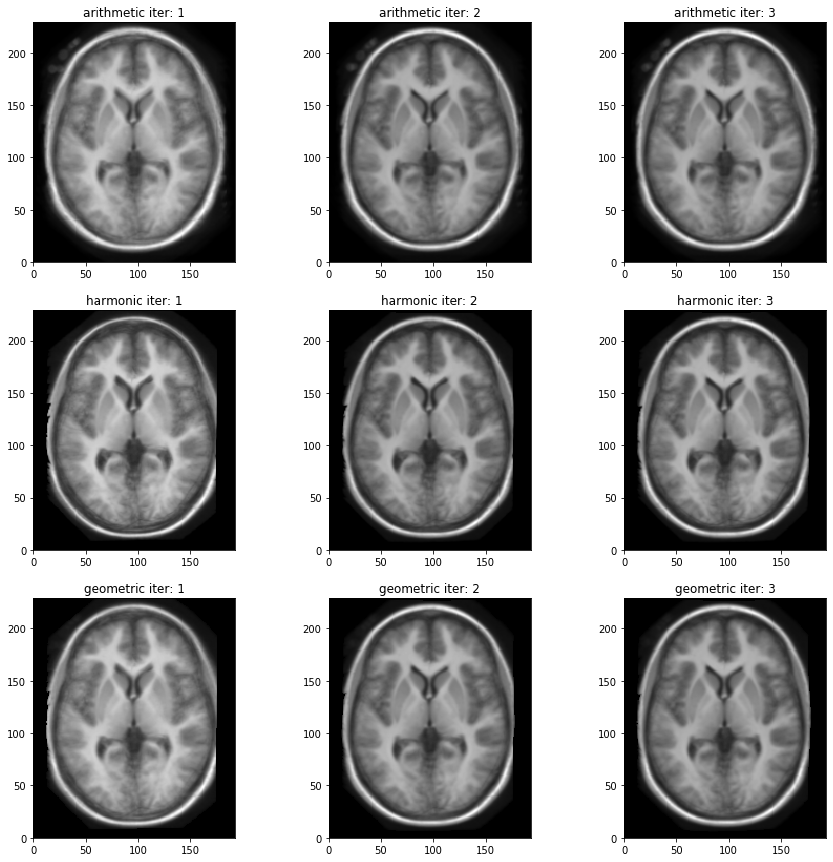

In [7]:
### BEGIN SOLUTION
# 1+1 geo har
# 2 izgradnja atlasa
# 1+1+1 shrani in prikaz 
# (.5 + 0.5 mv + 0.5 sba + 0.5)*3 poravnava in zlivanje in dice

# Koda iz vaj


def computeDiceCoeff(iS,iR):
    return 2.0*float(np.count_nonzero(iS * iR)) / \
        float(np.count_nonzero(iS) + np.count_nonzero(iR))


def bsplineRegistration(iFixed, iMoving, iBSplineGridSpacing=7, iMaxIter=50):
    iFixed = sitk.GetImageFromArray(iFixed.astype('float'))
    iMoving = sitk.GetImageFromArray(iMoving.astype('float'))
   
    # inicializacija postopka
    R = sitk.ImageRegistrationMethod()

    # inicializacija preslikave z B-zlepki
    bTr = sitk.BSplineTransformInitializer(iFixed, [iBSplineGridSpacing] * 2)
    R.SetInitialTransform(bTr, inPlace=True)

    # inicializacija mere podobnosti
    R.SetMetricAsMattesMutualInformation(64)
    R.SetMetricSamplingPercentage(0.1, seed=42)
    R.SetMetricSamplingStrategy(R.RANDOM)

    # inicializacija optimizacije
    R.SetOptimizerAsGradientDescentLineSearch(
        learningRate=5.0,
        numberOfIterations=iMaxIter,
        convergenceMinimumValue=1e-5,
        convergenceWindowSize=5)
    R.SetOptimizerScalesFromPhysicalShift()

    # zagon poravnave
    outTx = R.Execute(iFixed, iMoving)
    return outTx



def bsplineResample(iFixed, iMoving, iTx, iInterpType=sitk.sitkLinear):    
    ### YOUR CODE HERE
    iFixed = sitk.GetImageFromArray(iFixed.astype('float'))
    iMoving = sitk.GetImageFromArray(iMoving.astype('float'))

    # ustvarjanje izhodne slike
    S = sitk.ResampleImageFilter()
    S.SetReferenceImage(iFixed)
    S.SetInterpolator(iInterpType)
    S.SetDefaultPixelValue(0)
    S.SetTransform(iTx)
    outImage = S.Execute(iMoving)

    return sitk.GetArrayFromImage(outImage)

def fusionMajorityVoting(iMovingLabelMaps):
    labcount = []
    # ozadje
    labcount.append(np.sum((iMovingLabelMaps == 0).astype('uint8'), axis=-1))
    labels = np.unique(iMovingLabelMaps[iMovingLabelMaps != 0])
    # ospredje
    lab = []  # shranjujemo imena znack
    for k in labels:
        print(k)
        lab.append(k)
        labcount.append(np.sum((iMovingLabelMaps == k).astype('uint8'), axis=-1))
    idx = np.argmax(labcount,axis=0)
    oFixedLabelMap = np.zeros_like(idx)

    for i in range(1,len(lab)+1):  # odzadje = 0, za vse ostale zelimo imena originalnih znack
        oFixedLabelMap[idx == i] = lab[i-1]  
    return oFixedLabelMap


def fusionShapeBasedAveraging(iMovingLabelMaps):
    
    def distanceAverage(masks):
        dist = []
        
        for i in range(masks.shape[-1]):
            dismap = sitk.SignedMaurerDistanceMap(
                sitk.GetImageFromArray(masks[:, :, i].astype('uint8'))
                , squaredDistance=False)
            dist.append(sitk.GetArrayFromImage(dismap))
        
        return np.mean(np.stack(dist, axis=-1), axis=-1)
    
    labels = np.unique(iMovingLabelMaps[iMovingLabelMaps != 0]) 
    labdist = []
    # odzadje 
    labdist.append(distanceAverage(iMovingLabelMaps == 0))
    
    # ospredje
    lab= []
    for k in labels:
        lab.append(k)
        labdist.append(distanceAverage(iMovingLabelMaps == k ))  # povprecna razdalja do k-te znacke
        
    idx = np.argmin(labdist, axis=0)
    
    oFixedLabelMap = np.zeros_like(idx)
    for i in range(1,len(lab)+1):  # odzadje = 0, za vse ostale zelimo imena originalnih znack
        oFixedLabelMap[idx == i] = lab[i-1] 
    
    
    return oFixedLabelMap


# Domaca naloga
def atlasConstruction(images, type= 'arithmetic'):
    if type == 'arithmetic':
        return np.mean(images.astype('float'), axis=-1)
    elif type == 'geometric':
        return (np.prod(images.astype('float'), axis=-1)/images.shape[-1])**float(1.0/images.shape[-1])
    elif type == 'harmonic':
        return np.mean((images.astype('float') + 1e-7)**(-1.0), axis=-1)**(-1.0)

def atlasRegistration(images, masks, maxiter=5, outiter=False, verbose=True, type='mean'):
    pth_out = '/home/zbizjak/06-Razgradnja_s_poravnavo_atlasov/hwimages'
    reg_images = images
    reg_masks = []
    iter = 0
    while maxiter>0:
        if verbose:
            print('iteracija: {}'.format(iter))
            iter += 1
        atlas = atlasConstruction(reg_images, type=type)
        if outiter:
            # shranjevanje vmesne slike atlasa
            out_atlas = sitk.GetImageFromArray(atlas)
            sitk.WriteImage(sitk.Cast(out_atlas, sitk.sitkUInt16),
                           os.path.join(pth_out, 'atlas-{}-iter{}.nii.gz'.format(
                               type, iter)), True)
        reg_images = []
        reg_masks = []
        atlas_img = atlas
        for i in range(images.shape[-1]):
            if verbose:
                print('\tporavnava: {}/{}'.format(i+1, images.shape[-1]))
            img = images[:,:,i].astype('float')
            msk = masks[:,:,i]
            reg_tx = bsplineRegistration(atlas_img, img)
            reg_img =bsplineResample(atlas_img, img, reg_tx)
            reg_msk = bsplineResample(atlas_img, msk, reg_tx, sitk.sitkNearestNeighbor)
            reg_images.append(reg_img)
            reg_masks.append(reg_msk)
        reg_images = np.dstack(reg_images)
        maxiter -= 1
        
    images = reg_images
    masks = np.dstack(reg_masks)
    atlas = atlasConstruction(images)
    return atlas, images, masks

# izvajanje 
niter = 3
aatlas, aimages5, amasks5 = atlasRegistration(imgs, msks, maxiter=niter, type='arithmetic', outiter=True)
gatlas, gimages5, gmasks5 = atlasRegistration(imgs, msks, maxiter=niter, type='geometric', outiter=True)
hatlas, himages5, hmasks5 = atlasRegistration(imgs, msks, maxiter=niter, type='harmonic', outiter=True)


pth_out = '/home/zbizjak/06-Razgradnja_s_poravnavo_atlasov/hwimages'

# prikaz 
plt.rcParams['figure.figsize'] = [15, 15]

ltype = ['arithmetic', 'harmonic', 'geometric']
ncol = niter
nrow = 3
fix, ax = plt.subplots(nrow, ncol)
    
for i in range(3):
    for j in range(ncol):
        img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(pth_out, 'atlas-{}-iter{}.nii.gz'.format(
                                     ltype[i], j+1))))
        ax[i, j].imshow(img, cmap='gray', origin='lower')
        ax[i, j].set_xlim(0, img.shape[1])
        ax[i, j].set_ylim(0, img.shape[0])
        ax[i, j].set_title('{} iter: {}'.format(ltype[i], j+1))
        
        
### END SOLUTION

2. Knjižnica `SimpleITK` vključuje implementacijo postopka STAPLE (STAPLE: simultaneous truth and performance level estimation) za statistično zlivanje značk:
```python
	sitk.STAPLE(labelVector, confidenceWeight=1.0, foregroundValue=1.0, maximumIterations=N)
```
 Funkcija omogoča zlivanje binarnih mask, torej le mask, ki vsebujejo le značko ospredja in ozadja. Izhod funkcije je polje verjetnosti, iz katere lahko z upragovljanjem vrednosti nad 0.5 pridobimo masko značke ospredja. Zlivanja mask z večimi značkami ta implementacija ne omogoča, vendar jo lahko izvedemo tako, da vsako značko ločeno zlijemo in nato združimo v eno masko značk.

	* Preizkusite delovanje funkcije tako, da zlijete poravnane maske značk področja $l=1$ (kavdatno jedro), ki ste jih izračunali pri prejšnji nalogi z aritmetičnim povprečenjem (oz. v peti nalogi iz vaj). Preverite vpliv števila iteracij `N` na rezultat postopka in določite po vašem optimalno število iteracij. Pri tem si lahko pomagate z izračunom Diceovega koeficienta.

	* Napišite funkcijo za zlivanje mask z večimi značkami na osnovi dane implementacije postopka STAPLE:
	```python
		def fusionMultilabelSTAPLE( iLabelMaps ):
			return oLabelMap
        ```	
        kjer `iLabelMaps` predstavlja seznam (`list`) mask značk, funkcija pa vrne masko zlitih značk `oLabelMap`. 
    * Pri prejšnji nalogi (ali peti nalogi iz vaj) pridobljene poravnane rezine v `oImages` in maske maske značk `oLabelMaps` z aritmetičnim povprečenjem uporabite za razgradnjo prve rezine tako, da pri zlivanju izpustite prvo rezino. Vrednotite uspešnost razgradnje z Diceovim koeficientom in vizualno tako, da z zlivanjem pridobljeno masko značk izrišete in primerjate z masko ročno določenih značk na prvi rezini. 
    * Kako se obnese postopek zlivanja v primerjavi s postopkoma `fusionMajorityVoting()` ali `fusionShapeBasedAveraging()` iz prejšnje naloge, glede na vrednosti Diceovih koeficientov?



In [74]:
# prva tocka
dice = []
pmap = []
binmsk = []

labmask = (amasks5[:,:,1:] == 1).astype('int16')
labvect = [sitk.GetImageFromArray(labmask[:,:,z]) for z in range(labmask.shape[-1])]

labvect2 = sitk.GetImageFromArray(labmask) 

labfusion1 = sitk.STAPLE(labvect,1.0, 1.0,5)
    
staplemsk1 = sitk.GetArrayFromImage(labfusion1)

labfusion2 = sitk.STAPLE(labvect2,1.0, 1.0,5)
staplemsk2 = sitk.GetArrayFromImage(labfusion2)



iter: 0 Dice: 0.8759571209800919
iter: 1 Dice: 0.8785310734463276
iter: 2 Dice: 0.8772919605077574
iter: 3 Dice: 0.8776371308016878
iter: 4 Dice: 0.8776371308016878
iter: 5 Dice: 0.8792134831460674
iter: 6 Dice: 0.8792134831460674
iter: 7 Dice: 0.8792134831460674
iter: 8 Dice: 0.8746518105849582
iter: 9 Dice: 0.8746518105849582
iter: 10 Dice: 0.8746518105849582
iter: 11 Dice: 0.8746518105849582
iter: 12 Dice: 0.8746518105849582
iter: 13 Dice: 0.8746518105849582
iter: 14 Dice: 0.8746518105849582
best iter: 5
Computing staple
Izhoda fusionMultilabelSTAPLE in fusionMultilabelSTAPLE2 enaka?: False
Stevilo enakih pikslov: 44162	 Stevilo ralicnih pikslov: 35
Dice(CAUDATE)=0.876
Dice(PALLIDUM)=0.802
Dice(PUTAMEN)=0.879
Dice(THALAMUS)=0.881
Dice(CORTEX)=0.742
Average:  0.836


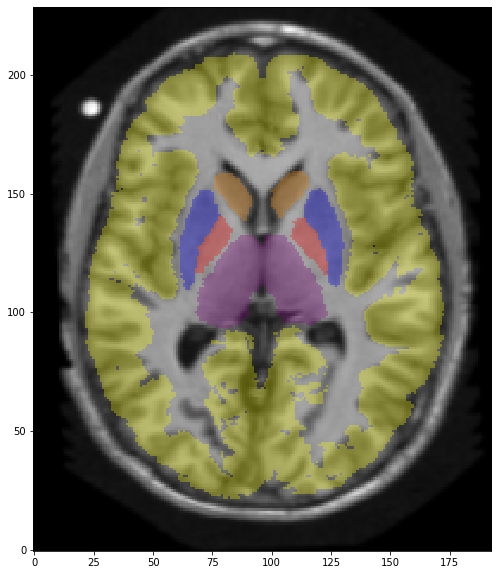

In [73]:
### BEGIN SOLUTION 

# 1.5 za zlivanje kavdalnega jedra; 0.5 za določanje optimalnega N -> 
# 3 za posplositev
# 2 povprecenje z zlivanjem 
# 2 
# 1 komentar
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def evalDice(iFixedMask,iMovingMask):
    oDice=[]
    for (i, l_name) in LABELS.items():
        oDice_t = computeDiceCoeff(iFixedMask==i, iMovingMask==i)
        oDice.append(oDice_t)
        print('Dice({})={:.3f}'.format(l_name.upper(), oDice_t))
    return oDice
mask_cmap = ListedColormap([[0., 0., 0., 0.], 'darkorange', 'red', 'blue', 'purple', 'yellow'])

# prva tocka
dice = []
pmap = []
binmsk = []
for i in np.arange(15):
    labmask = (amasks5[:,:,1:] == 1).astype('int16')
    labvect = [sitk.GetImageFromArray(labmask[:,:,z]) for z in range(labmask.shape[-1])]
    labfusion = sitk.STAPLE(labvect,1.0, 1.0, int(i))
    
    staplemsk = sitk.GetArrayFromImage(labfusion)
    pmap.append(staplemsk)
    
    binmsk.append((staplemsk >= 0.5).astype('uint8'))

    oDice = computeDiceCoeff((amasks5[:,:,0]==1).astype('uint8'), binmsk[i])
    dice.append(oDice)
    print('iter: {} Dice: {}'.format(i, oDice))
print('best iter: {}'.format(np.argmax(np.array(dice))))
best_iter = np.argmax(np.array(dice))



def fusionMajorityVoting(iMovingLabelMaps):
    labcount = []
    # ozadje
    labcount.append(np.sum((iMovingLabelMaps == 0).astype('uint8'), axis=-1))
    labels = np.unique(iMovingLabelMaps[iMovingLabelMaps != 0])
    # ospredje
    lab = []  # shranjujemo imena znack
    for k in labels:
        print(k)
        lab.append(k)
        labcount.append(np.sum((iMovingLabelMaps == k).astype('uint8'), axis=-1))
    idx = np.argmax(labcount,axis=0)
    oFixedLabelMap = np.zeros_like(idx)

    for i in range(1,len(lab)+1):  # odzadje = 0, za vse ostale zelimo imena originalnih znack
        oFixedLabelMap[idx == i] = lab[i-1]  
    return oFixedLabelMap
  
def fusionMultilabelSTAPLE( iLabelMaps, N):   # boljsa opcija
    # iLabelMaps je seznam -> array
    iLabelMaps = np.dstack(iLabelMaps)
    # značke
    labels = np.unique(iLabelMaps[iLabelMaps != 0])

    labcount = []
    # ozadje
    labcount.append(np.sum((iLabelMaps == 0).astype('uint8'), axis=-1)/iLabelMaps.shape[-1])
    
    #ospredje
    out_msk = np.zeros( iLabelMaps.shape[:2])
    lab = []  # shranjujemo imena znack
    for k in labels:
        lab.append(k)
        labmask = (iLabelMaps == k).astype('uint32')
        labvect = [sitk.GetImageFromArray(labmask[:,:,z]) for z in range(labmask.shape[-1])] 
        
        labfusion = sitk.STAPLE(labvect, 1.0, 1.0, int(N))
        # labfusion = sitk.STAPLE(labvect, confidenceWeight=1.0, foregroundValue=1.0, maximumIterations=5)
        labfusion = sitk.GetArrayFromImage(labfusion)
        labfusion[np.isnan(labfusion)] = 0.0
        labcount.append(labfusion)
    
    idx = np.argmax(labcount,axis=0)
    oFixedLabelMap = np.zeros_like(idx)
    
    for i in range(1,len(lab)+1):  # odzadje = 0, za vse ostale zelimo imena originalnih znack
        oFixedLabelMap[idx == i] = lab[i-1]  
    
    return oFixedLabelMap


def fusionMultilabelSTAPLE2( iLabelMaps, N):   # slabsa opcija
    # iLabelMaps je seznam -> array
    iLabelMaps = np.dstack(iLabelMaps)

    out_msk = np.zeros( iLabelMaps.shape[:2])
    
    labels = np.unique(iLabelMaps[iLabelMaps!=0])
    for k in labels:
        labmask = (iLabelMaps == k).astype('uint32')
        labvect = [sitk.GetImageFromArray(labmask[:,:,z]) for z in range(labmask.shape[-1])] 
        
        labfusion = sitk.STAPLE(labvect, 1.0, 1.0, int(N))
        # labfusion = sitk.STAPLE(labvect, confidenceWeight=1.0, foregroundValue=1.0, maximumIterations=5)
        labfusion = sitk.GetArrayFromImage(labfusion)
        labfusion[np.isnan(labfusion)] = 0.0
        out_msk[labfusion>0.5] = k    # TOLE nam je manj vsec kot argmax
    return out_msk

print('Computing staple')

out_staple  = '/home/aralralud/05-Razgradnja_s_poravnavo_atlasov/hw-images'
staple_msk = fusionMultilabelSTAPLE([amasks5[:,:,i] for i in range(1, amasks5.shape[-1])], best_iter)
staple_msk2 = fusionMultilabelSTAPLE2([amasks5[:,:,i] for i in range(1, amasks5.shape[-1])], best_iter)
# Se maski razlikujeta?
print("Izhoda fusionMultilabelSTAPLE in fusionMultilabelSTAPLE2 enaka?: {}".format(
    np.all(staple_msk==staple_msk2)))

same = np.sum(staple_msk==staple_msk2)
diff = staple_msk.size - same
print("Stevilo enakih pikslov: {}\t Stevilo ralicnih pikslov: {}".format(same, diff))

# referencna slika in maska - prva rezina poravnanih slik
ref_msk = amasks5[:,:,0]    
ref_img = aimages5[: ,:,0]  

dice_staple = np.round(np.mean(np.array(evalDice(ref_msk, staple_msk))), 3)
print('Average: ', dice_staple)
plt.figure(figsize=(10,10))
plt.imshow(ref_img, cmap='gray', origin='lower')
plt.imshow(staple_msk, cmap=mask_cmap, origin='lower', alpha=0.3)
plt.show()


### END SOLUTION